In [ ]:
import pandas as pd
import numpy as np
import re
import string
import spacy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
!python3 -m spacy download en_core_web_sm

In [ ]:
pd.set_option('max_colwidth', 400)

### Набор данных
[
SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being **ham** (legitimate) or **spam**.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/uciml/sms-spam-collection-dataset/versions/1


In [ ]:
data = pd.read_csv('/root/.cache/kagglehub/datasets/uciml/sms-spam-collection-dataset/versions/1/spam.csv', encoding='iso-8859-1')[['v1', 'v2']].rename(
    columns={'v1': 'label', 'v2': 'text'}
)
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [ ]:
data['label'].value_counts()

,count
label,
ham,4825
spam,747


In [ ]:
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

### Очистка

Стоп-слова для английского языка в spaCy

In [ ]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
print(f'Spacy english stopwords size: {len(stopwords)}', end='\n\n')
' '.join(stopwords)

Spacy english stopwords size: 326



"who them least therefore among how even himself nor why 've hence ‘re about there some such make once former of an part used never sometimes between been first becomes these over sometime against those four yourselves above being whereby could anyone doing nowhere which besides myself most together that empty onto beforehand upon noone we meanwhile wherever whence or before anything was twelve someone either hereafter no nevertheless formerly while until hundred seeming through many name back became but after quite 's me do nobody sixty she be will their off whatever both put thereafter done neither become up into have across enough go your whenever others everywhere during please you move beyond though well give already ever something three must did say none thereby made below namely per nine now other since next take whereupon here a regarding should everyone ’re few less toward fifty at his thru bottom same under so any would anyhow five side due can beside mostly nothing just ours

Атрибуты [Token](https://spacy.io/api/token#attributes)

In [ ]:
%%time

data['cleaned_text'] = data['text'].apply(
    lambda x: ' '.join(
        token.lemma_.lower() for token in nlp(x) if
        not token.is_stop
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    )
)
data.sample(5)

CPU times: user 58.5 s, sys: 174 ms, total: 58.6 s
Wall time: 1min 13s


,label,text,cleaned_text
5044,0,"We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us",send jd customer service cum account executive ur mail d detail contact
2491,0,"Greetings me, ! Consider yourself excused.",greeting consider excuse
2861,1,Adult 18 Content Your video will be with you shortly,adult content video shortly
2052,1,"Call 09094100151 to use ur mins! Calls cast 10p/min (mob vary). Service provided by AOM, just GBP5/month. AOM Box61,M60 1ER until u stop. Ages 18+ only!","use ur min call cast 10p min mob vary service provide aom gbp5 month aom box61,m60 1er u stop age +"
2899,0,Come aftr &lt;DECIMAL&gt; ..now i m cleaning the house,come aftr lt;decimal&gt m clean house


In [ ]:
data['cleaned_text'].iloc[3]

'u dun early hor u c'

### Bag of words

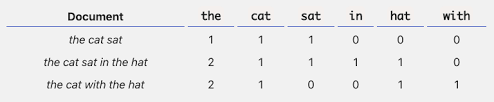

#### CountVectorizer

- приводит к нижнему регистру
- проводит токенизацию - `r"(?u)\b\w\w+\b"` (токены из 2 или более буквенно-цифровых символов, пунктуация полностью игнорируется и всегда рассматривается как разделитель токенов)
  - `(?u)` - флаг Unicode
  - `\b` - граница слова
  - `\w` - символы, которые могут входить в состав слов, включая числа и подчёркивание
  - `\+` - 1 и более повторений предшествующего выражения
- фильтрует стоп-слова

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

##### Стоп-слова

In [ ]:
print(f'Sklearn english stopwords size: {len(ENGLISH_STOP_WORDS)}', end='\n\n')
' '.join(ENGLISH_STOP_WORDS)

Sklearn english stopwords size: 318



'who them least therefore among how even describe couldnt himself nor why hence about there some such once former of an part never interest sometimes between been first becomes these over sometime against those four yourselves above being whereby could anyone nowhere amoungst which besides myself most together that empty onto beforehand upon bill noone co we meanwhile wherever whence or before anything was twelve someone either hereafter no nevertheless formerly while until hundred seeming through many name back became but after me con do nobody sixty thin she be will their off whatever both put thereafter detail done neither become up into have across enough go your whenever others everywhere during please you move beyond though well give already ever something three must none thereby made below namely per nine now other since next take whereupon here a should everyone few less toward fifty at his eg thru bottom same under so any would anyhow five side due can cry mill beside mostly n

This list of English stop words is taken from the "Glasgow Information Retrieval Group". The original list can be found at
http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words


##### Проблемы со встроенными списками стоп-слов



[Stop Word Lists in Free Open-source Software Packages](https://aclanthology.org/W18-2502.pdf)

*   Спорные стоп-слова: system,
*   Несовместимость с некоторыми токенизаторами
*   Неполнота



##### Train/test split & fit

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], random_state=2023)

In [ ]:
vectorizer = CountVectorizer(max_df=0.7, min_df=0.003) # max_df фильтрует corpus-specific stop words
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

##### Разреженное представление результата

Поскольку в большинстве документов обычно используется очень небольшое подмножество слов, используемых в корпусе, результирующая матрица будет иметь много нулевых значений признаков (обычно более 99% из них).

Чтобы оптимально хранить такую матрицу в памяти, а также ускорить алгебраические операции с матрицей/вектором, обычно используют разреженное представление, такое как реализации, доступные в пакете scipy.sparse.


[Sparse matrices (scipy.sparse)](https://docs.scipy.org/doc/scipy/reference/sparse.html)

**CSR** - Compressed Sparse Row

**COO** - COOrdinate format

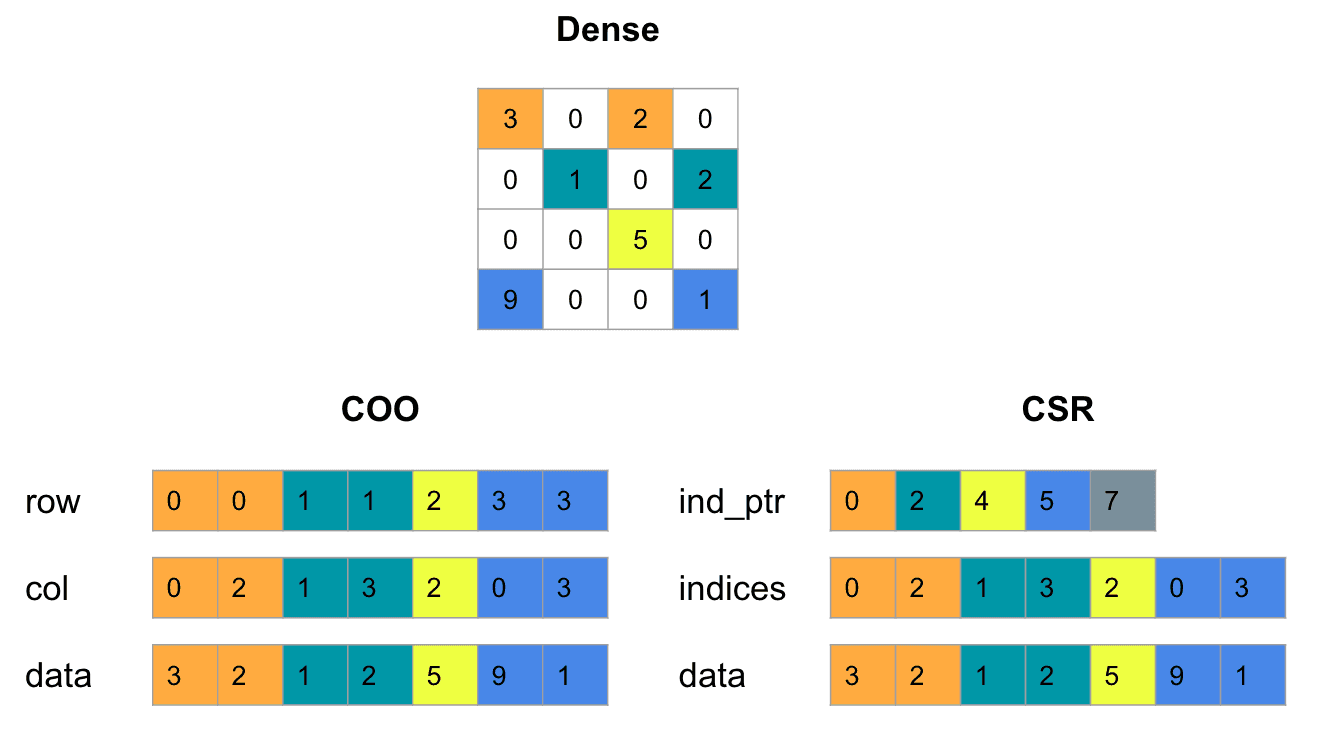

In [ ]:
X_train_vectorized

<4179x449 sparse matrix of type '<class 'numpy.int64'>'
	with 18003 stored elements in Compressed Sparse Row format>

In [ ]:
vectorizer.get_feature_names_out()

array(['000', '10', '100', '1000', '10p', '150p', '150ppm', '2000', '50',
       '500', '5000', 'able', 'abt', 'account', 'actually', 'add',
       'address', 'aft', 'afternoon', 'ah', 'aight', 'alright', 'amp',
       'answer', 'anytime', 'apply', 'ard', 'ask', 'attempt', 'await',
       'award', 'away', 'babe', 'baby', 'bad', 'beautiful', 'bed',
       'believe', 'big', 'birthday', 'bit', 'bonus', 'book', 'bored',
       'box', 'boy', 'boytoy', 'break', 'bring', 'brother', 'bt', 'bus',
       'busy', 'buy', 'call', 'camera', 'car', 'card', 'care', 'cash',
       'cause', 'chance', 'change', 'charge', 'chat', 'check', 'chikku',
       'choose', 'claim', 'class', 'close', 'co', 'code', 'collect',
       'collection', 'colour', 'com', 'come', 'confirm', 'contact',
       'cool', 'cos', 'cost', 'coz', 'crazy', 'credit', 'cs', 'cum',
       'customer', 'da', 'dad', 'darlin', 'dat', 'date', 'day', 'de',
       'dear', 'decide', 'decimal', 'delivery', 'den', 'detail', 'dinner',
       'dis'

In [ ]:
pd.DataFrame(X_train_vectorized.toarray(), columns=vectorizer.get_feature_names_out()).head()

,000,10,100,1000,10p,150p,150ppm,2000,50,500,...,xxx,ya,yeah,year,yes,yesterday,yo,you,yup,ìï
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Бейзлайн

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

Константное предсказание

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train_vectorized, y_train)
preds = dummy_clf.predict(X_test_vectorized)
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1207
           1       0.00      0.00      0.00       186

    accuracy                           0.87      1393
   macro avg       0.43      0.50      0.46      1393
weighted avg       0.75      0.87      0.80      1393



Логистическая регрессия

In [ ]:
logreg = LogisticRegression().fit(X_train_vectorized, y_train)
preds = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1207
           1       0.97      0.82      0.89       186

    accuracy                           0.97      1393
   macro avg       0.97      0.91      0.94      1393
weighted avg       0.97      0.97      0.97      1393



##### Переопределение токенизатора, препроцессинга

In [ ]:
def custom_tokenize(text):
  text = re.sub(r'[^a-zA-Z ]', '', text)
  return text.split()

In [ ]:
custom_vectorizer = CountVectorizer(
    max_df=0.7,
    min_df=0.003,
    tokenizer=custom_tokenize, # аналогично можно переопределить preprocessor
)
X_train_vectorized = custom_vectorizer.fit_transform(X_train)
X_test_vectorized = custom_vectorizer.transform(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
X_train_vectorized

<4179x445 sparse matrix of type '<class 'numpy.int64'>'
	with 18709 stored elements in Compressed Sparse Row format>

In [ ]:
pd.DataFrame(X_train_vectorized.toarray(), columns=custom_vectorizer.get_feature_names_out()).head()

,able,abt,account,actually,add,address,aft,afternoon,age,ah,...,xmas,xxx,y,ya,yeah,year,yes,yesterday,yo,yup
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
logreg = LogisticRegression().fit(X_train_vectorized, y_train)
preds = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1207
           1       0.99      0.83      0.90       186

    accuracy                           0.98      1393
   macro avg       0.98      0.92      0.95      1393
weighted avg       0.98      0.98      0.98      1393



### Tf-Idf

В объемном корпусе некоторые слова будут присутствовать в большом количестве документов (текстов), а значит, они несут очень мало значимой информации о фактическом содержании документа.

Для решения этой проблемы можно использовать Tf-Idf подход

Цель использования tf-idf состоит в том, чтобы уменьшить влияние токенов, которые очень часто встречаются в данном корпусе и, следовательно, эмпирически менее информативны, чем признаки, которые встречаются малой части корпуса



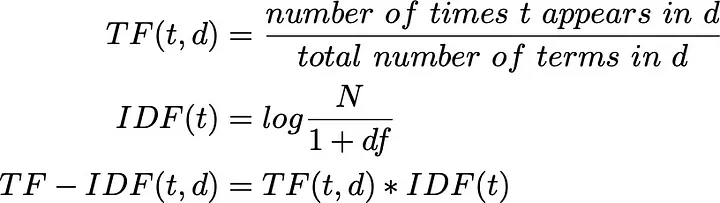

#### Отличия в реализации Sklearn

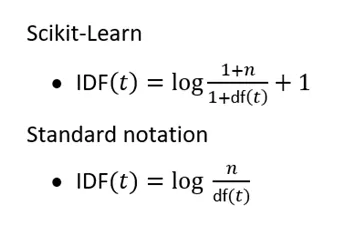

Также в Scikit-Learn результирующие векторы TF-IDF нормализуются по евклидовой норме, что облегчает расчет cosine similarity:
`The cosine similarity between two vectors is their dot product when l2 norm has been applied`

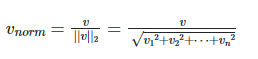

#### TfidfTransformer vs  TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer,  TfidfVectorizer
from sklearn.pipeline import Pipeline

**TfidfTransformer** преобразует матрицу из CountVectorizer в tf-idf

In [ ]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression())
    ]
).fit(X_train, y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1207
           1       0.99      0.70      0.82       186

    accuracy                           0.96      1393
   macro avg       0.97      0.85      0.90      1393
weighted avg       0.96      0.96      0.96      1393



**TfidfVectorizer** работает end-to-end

In [ ]:
pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression())
    ]
).fit(X_train, y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1207
           1       0.99      0.70      0.82       186

    accuracy                           0.96      1393
   macro avg       0.97      0.85      0.90      1393
weighted avg       0.96      0.96      0.96      1393



#### Визуализация & Интерпретация

##### Altair

[Altair](https://github.com/altair-viz/altair) - declarative statistical visualization library for Python

In [ ]:
tfidf = TfidfVectorizer(tokenizer=custom_tokenize, max_df=0.7, min_df=0.003, )
transformed = tfidf.fit_transform(X_train)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
tfidf_df = pd.DataFrame(transformed.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df = tfidf_df.stack().reset_index().rename(columns={0: 'tfidf', 'level_0': 'document', 'level_1': 'term', 'level_2': 'term'})
tfidf_df = tfidf_df.sort_values(by=['document', 'tfidf'], ascending=[True, False]).groupby(['document']).head()
tfidf_df.head()

,document,term,tfidf
284,0,place,0.884920
213,0,lot,0.465743
0,0,able,0.000000
1,0,abt,0.000000
2,0,account,0.000000


In [ ]:
tfidf_df.iloc[100:200]

,document,term,tfidf
9340,20,year,0.576344
9058,20,happy,0.560810
9149,20,new,0.506715
9292,20,u,0.310741
8900,20,able,0.000000
...,...,...,...
17686,39,send,0.757523
17639,39,place,0.341287
17593,39,money,0.340000
17723,39,text,0.268107


In [ ]:
import altair as alt

In [ ]:
term_list = ['free', 'money']

top_tfidf_df = tfidf_df[tfidf_df['tfidf'] != 0]

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_df.iloc[300:400]).encode(
    x = 'rank:O',
    y = 'document:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["document"],
)

heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

circle = base.mark_circle(size=100).encode(
    color = alt.condition(
        alt.FieldOneOfPredicate(field='term', oneOf=term_list),
        alt.value('red'),
        alt.value('#FFFFFF00')
    )
)

# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + circle + text).properties(width = 600) #circle

alt.LayerChart(...)

[Altair examples](https://altair-viz.github.io/gallery/index.html#interactive-charts)

##### ELI5

[eli5](https://eli5.readthedocs.io/en/latest/) - Python library which allows to visualize and debug various Machine Learning models using unified API. It has built-in support for several ML frameworks and provides a way to explain black-box models.

In [ ]:
%%capture
!pip install eli5 scikit-learn==1.2.2 -U

In [ ]:
import eli5

In [ ]:
eli5.show_weights(
    estimator=pipe['clf'],
    feature_names=list(pipe['tfidf'].get_feature_names_out()),
    top=(50, 5)
)

Weight?,Feature
+4.363,txt
+3.851,claim
+3.709,mobile
+3.428,www
+3.274,150p
+3.212,win
+3.058,free
+3.047,service
+2.979,stop
+2.855,chat


[TextExplainer: debugging black-box text classifiers](https://eli5.readthedocs.io/en/latest/tutorials/black-box-text-classifiers.html)

[Debugging scikit-learn text classification pipeline](https://eli5.readthedocs.io/en/latest/tutorials/sklearn-text.html)